<a href="https://colab.research.google.com/github/Mlaouan/IA-covid-fake-news-detection/blob/main/projetIA%20fake%20news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Projet IA***

# Importation des données

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split



# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

#rn
from tensorflow import keras


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Analyse

In [ ]:
#LOADING DATA
df_train=pd.read_excel('drive/My Drive/Colab Notebooks/Data-FakeRealCOVID.xlsx')
print(df_train.shape)
df_train.head()
df_train

(6420, 3)


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


In [ ]:
#UN PEU D'ANALYSE 

print(df_train.columns.tolist())

['id', 'tweet', 'label']


real    3360
fake    3060
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


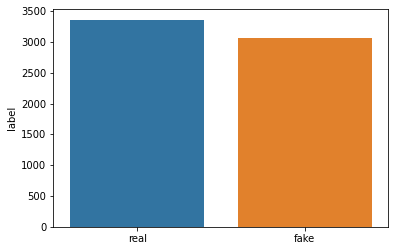

In [ ]:
# CLASS DISTRIBUTION
x=df_train['label'].value_counts()
print(x)
sns.barplot(x.index,x) ##representation des diff variables du label real/fake


In [ ]:
#Missing values
df_train.isna().sum()


id       0
tweet    0
label    0
dtype: int64

In [ ]:
#WORD-COUNT (return average)
df_train['word_count'] = df_train['tweet'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['label']=='real']['word_count'].mean()) #real tweets
print(df_train[df_train['label']=='fake']['word_count'].mean()) #fake tweets
#real tweets are more wordy than the fake ones


31.676488095238096
21.865359477124183


In [ ]:
#CHARACTER-COUNT(return average)
df_train['char_count'] = df_train['tweet'].apply(lambda x: len(str(x)))
print(df_train[df_train['label']=='real']['char_count'].mean()) #real tweets
print(df_train[df_train['label']=='fake']['char_count'].mean()) #fake tweets
#real tweets are longer than the fake ones


215.0613095238095
144.8875816993464


In [ ]:
#UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['tweet'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['label']=='real']['unique_word_count'].mean()) #real tweets
print(df_train[df_train['label']=='fake']['unique_word_count'].mean()) #fake tweets


28.428571428571427
19.99640522875817


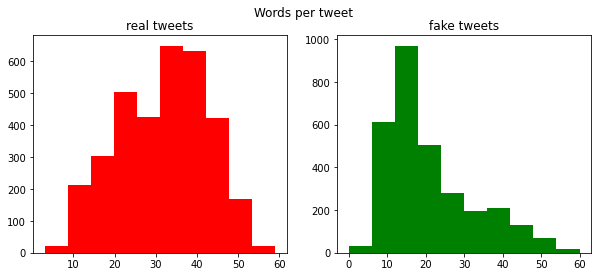

In [ ]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['label']=='real']['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('real tweets')
train_words=df_train[df_train['label']=='fake']['word_count']
ax2.hist(train_words,color='green' , range=(0,60) )
ax2.set_title('fake tweets')
fig.suptitle('Words per tweet')
plt.show()


# PHASE DE PRE-PROCESSING

## Emoji

In [ ]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

## Convert to lowercase and remove punctuations and characters and strip..

In [ ]:

def preprocess(text):
    text = text.lower() #lowercase text
    text = text.strip()  #get rid of leading/trailing whitespace supprime les espaces au debut et a la fin de la phrase
    text = re.sub("https?:\/\/.*[\r\n]*", "", text) #liens
    text = re.sub("@\S+", "",text) #mentions#####
    text = re.sub("#\S+", "", text) #hastags#####
    text = re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub("[0-9]\S+", "", text) #numbers+letters#######
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...) remove numbers between []
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits remove numbers found in string
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    text = re.sub("corona\S+", "covid",text) #derivés de covid######

    return text


## Stopword removal

In [ ]:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


## Stemming

In [ ]:
#(slicing the end or the beginning of words with the intention of removing affixes(prefix/suffix))
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)


## Lemmatization

In [ ]:
#(reducing the word to its base form)

# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [ ]:
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)



##1.5. Final processing

In [ ]:
def finalpreprocess(string):
    return lemmatizer(preprocess(deEmojify(stopword(string))))


In [ ]:
df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])

In [ ]:
## mettre real fake dans 0 1 pour le RN
df_train['redif_label'] = df_train['label']
df_train['redif_label']=df_train['redif_label'].replace('real', 1)
df_train['redif_label']=df_train['redif_label'].replace('fake', 0)
df_train.head()

,id,tweet,label,clean_tweet,redif_label
0,1,The CDC currently reports 99031 deaths. In gen...,real,the cdc currently report death in general disc...,1
1,2,States reported 1121 deaths a small rise from ...,real,state report death small rise last tuesday sou...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost use pandemic ...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,we test laboratory india august test do dg,1
4,5,Populous states can generate large case counts...,real,populous state generate large case count look ...,1


# PHASE DE VECTORISATION

## Séparation des données

In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION 
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_tweet"],
                                                  df_train["redif_label"],
                                                  test_size=0.2,
                                                  shuffle=True)

## Bag of words TF-IDF

In [ ]:
#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_fit = tfidf_vectorizer.fit(X_train)
X_train_vectors_tfidf=X_train_vectors_fit.transform(X_train)
# Only transform x_test (not fit and transform)
#X_val_vectors_fit = tfidf_vectorizer.fit(X_val) 
#val_tokens=X_val_vectors_fit.get_feature_names_out()
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)
#Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible

In [ ]:
shape=X_train_vectors_tfidf.shape[1]
shape

8074

# PHASE D'APPRENTISSAGE

## Création du RN

In [ ]:
def get_model(shape):
    model=keras.models.Sequential()
    model.add(keras.layers.Dense(units=shape/10, activation='relu', kernel_initializer='uniform', input_dim=shape))
    model.add(keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer='uniform'))
    model.compile(optimizer='adam',
                 loss='mse',
                 metrics=['binary_accuracy'])
    return model

In [ ]:
model=get_model(shape)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 807)               6516525   
                                                                 
 dense_15 (Dense)            (None, 1)                 808       
                                                                 
Total params: 6,517,333
Trainable params: 6,517,333
Non-trainable params: 0
_________________________________________________________________


## Entrainement

In [ ]:
history=model.fit(X_train_vectors_tfidf.toarray(), y_train, batch_size=1000, epochs=10, verbose=1, validation_data=(X_val_vectors_tfidf.toarray(), y_val))

Epoch 1/10
6/6 [==============================] - 3s 433ms/step - loss: 0.2445 - binary_accuracy: 0.6384 - val_loss: 0.2317 - val_binary_accuracy: 0.6924
Epoch 2/10
6/6 [==============================] - 2s 402ms/step - loss: 0.2215 - binary_accuracy: 0.7856 - val_loss: 0.2064 - val_binary_accuracy: 0.7897
Epoch 3/10
6/6 [==============================] - 2s 404ms/step - loss: 0.1905 - binary_accuracy: 0.8699 - val_loss: 0.1744 - val_binary_accuracy: 0.8435
Epoch 4/10
6/6 [==============================] - 2s 401ms/step - loss: 0.1535 - binary_accuracy: 0.9163 - val_loss: 0.1405 - val_binary_accuracy: 0.8871
Epoch 5/10
6/6 [==============================] - 2s 406ms/step - loss: 0.1161 - binary_accuracy: 0.9408 - val_loss: 0.1096 - val_binary_accuracy: 0.9089
Epoch 6/10
6/6 [==============================] - 2s 401ms/step - loss: 0.0846 - binary_accuracy: 0.9531 - val_loss: 0.0874 - val_binary_accuracy: 0.9167
Epoch 7/10
6/6 [==============================] - 2s 401ms/step - loss: 0.06

## Evaluation des performances

In [ ]:
score=model.evaluate(X_val_vectors_tfidf.toarray(), y_val, verbose=1)
score_train=model.evaluate(X_train_vectors_tfidf.toarray(), y_train, verbose=1)
print('x_train/loss       : {:5.4f}'.format(score_train[0]))
print('x_train/accuracy   : {:5.4f}'.format(score_train[1]))
print('x_test/loss       : {:5.4f}'.format(score[0]))
print('x_test/accuracy   : {:5.4f}'.format(score[1]))

161/161 [==============================] - 2s 13ms/step - loss: 0.0251 - binary_accuracy: 0.9819
x_train/loss       : 0.0251
x_train/accuracy   : 0.9819
x_test/loss       : 0.0565
x_test/accuracy   : 0.9346


In [ ]:
df_h=pd.DataFrame(data=history.history)
df_h

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.244453,0.638435,0.231709,0.692368
1,0.221513,0.785631,0.206359,0.789720
2,0.190480,0.869938,0.174424,0.843458
3,0.153505,0.916277,0.140493,0.887072
4,0.116074,0.940810,0.109622,0.908879
5,0.084634,0.953076,0.087401,0.916667
6,0.062235,0.958333,0.073439,0.922118
7,0.047110,0.965732,0.065150,0.924455
8,0.036737,0.972547,0.060282,0.930685
9,0.029145,0.978972,0.056529,0.934579


## Prédiction données de test

In [ ]:
prediction=model.predict(X_val_vectors_tfidf.toarray())


In [ ]:
print(prediction)

[[0.01215309]
 [0.0601899 ]
 [0.76805776]
 ...
 [0.67973936]
 [0.8468095 ]
 [0.9382051 ]]


In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_val, prediction.round())
print('Confusion Matrix:')
print(confusion_matrix(y_val, prediction.round()))

Confusion Matrix:
[[571  50]
 [ 34 629]]


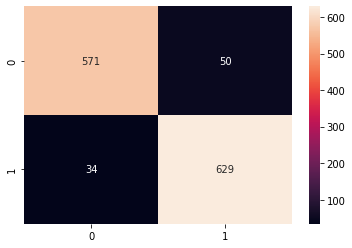

In [ ]:
DetaFrame_cm = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True, fmt='d')
plt.show()

In [ ]:
y_val=y_val.replace(1,'real')
y_val=y_val.replace(0,'fake')

In [ ]:
print(f"prediction: {prediction.round()}")
redif_prediction=['']*len(prediction)
for i in range(len(prediction)):
  if prediction.round()[i]==1:
    redif_prediction[i]='real'
  else:
    redif_prediction[i]='fake'
print(f"prediction categorie: {redif_prediction}")
print(f"reality: {y_val}")


prediction: [[0.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
prediction categorie: ['fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 're

In [ ]:
redif_prediction=['test']*len(prediction)
for i in range(len(prediction)):
  if prediction.round()[i]==1:
    redif_prediction[i]='real'
  else:
    redif_prediction[i]='fake'
print(f"prediction: {redif_prediction}")


prediction: ['fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 're

# INTERFACE GRAPHIQUE

In [ ]:
!pip install gradio

In [ ]:
def predict_text(tweet):
  redif_predict=''
  texte=finalpreprocess(tweet)
  s=pd.Series(texte)
  s_tdidf=tfidf_vectorizer.transform(s)
  predict=model.predict(s_tdidf.toarray())
  if predict.round()==1:
    redif_predict='real'
  else:
    redif_predict='fake'
  return redif_predict


In [ ]:
import gradio as gr
gr.Interface(predict_text, "textbox", outputs=gr.outputs.Textbox()).launch()


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://58763.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fe9d30d8f50>,
 'http://127.0.0.1:7867/',
 'https://58763.gradio.app')